<a href="https://colab.research.google.com/github/sohamhans19994/Compiler-Design/blob/master/Image_colorization_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd 
from skimage import io, color
import skimage
import matplotlib.pyplot as plt
import cv2
import numpy as np

import os

In [ ]:
gray_scale = np.load('/content/drive/My Drive/Image_Colorization/l/gray_scale.npy')[:3000]
print(gray_scale.shape)

(3000, 224, 224)


In [ ]:
ab_scale = np.load('/content/drive/My Drive/Image_Colorization/ab/ab/ab1.npy')[:3000]
# rgb2 = np.load('/content/drive/My Drive/Image_Colorization/ab/ab/ab2.npy')
# rgb3 = np.load('/content/drive/My Drive/Image_Colorization/ab/ab/ab3.npy')
# print(rgb1.shape,rgb2.shape,rgb3.shape)
print(ab_scale.shape)

(3000, 224, 224, 2)


In [ ]:
def display(img):
    plt.figure()
    plt.set_cmap('gray')
    plt.imshow(img)
    plt.show()


def combineLAB(l, a, b):
    shape = (l.shape[0], l.shape[1], 3)
    zeros = np.zeros(shape)
    zeros[:, :, 0] = l
    zeros[:, :, 1] = a
    zeros[:, :, 2] = b
    return zeros


def combineAB(a, b):
    shape = (a.shape[0], b.shape[1], 2)
    zeros = np.zeros(shape)
    zeros[:, :, 0] = a
    zeros[:, :, 1] = b
    return zeros


def combineL_AB(l, ab):
    shape = (l.shape[0], l.shape[1], 3)
    zeros = np.zeros(shape)
    zeros[:, :, 0] = l
    zeros[:, :, 1] = ab[:, :, 0]
    zeros[:, :, 2] = ab[:, :, 1]
    return zeros


def make3channels(gray):
    shape = (gray.shape[0], gray.shape[1], 3)
    zeros = np.zeros(shape)
    zeros[:, :, 0] = gray
    zeros[:, :, 1] = gray
    zeros[:, :, 2] = gray
    return zeros


def get_l_from_gray(img_path):
    img = io.imread(img_path)
    img = skimage.transform.resize(img,(64,64))
    gray = color.rgb2gray(img)
    gray = make3channels(gray)
    lgray = color.rgb2lab(gray, illuminant='D50')[:, :, 0]
    return lgray


def get_ab_from_file(file):
    img = io.imread(file)
    ab = np.zeros((64, 64, 2))
    ab[:, :, 0] = img[:, :, 1]
    ab[:, :, 1] = img[:, :, 2]
    return ab


def lab_normal_image(path):
    l, ab = load_img_for_training(path)
    l, ab = (l-127.5)/127.5, (ab-127.5)/127.5
    return l, ab


def rgb_image(l, ab):
    shape = (l.shape[0],l.shape[1],3)
    img = np.zeros(shape)
    img[:,:,0] = l[:,:,0]
    img[:,:,1:]= ab
    img = img.astype('uint8')
    img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
    return img


def load_img_for_training(img_path):
    img = io.imread(img_path)
    img = skimage.transform.resize(img,(64,64))
    lab = color.rgb2lab(img, illuminant='D50')
    l, a, b = lab[:, :, 0], lab[:, :, 1], lab[:, :, 2]
    ab = combineAB(a, b)
    lgray = get_l_from_gray(img_path)
    return lgray, ab


def save_ab_file(image, filepath):
    # add in 0zeros to its first component
    shape = (image.shape[0], image.shape[1], 3)
    new_ab_image = np.zeros(shape)
    new_ab_image[:, :, 1] = image[:, :, 0]
    new_ab_image[:, :, 2] = image[:, :, 1]
    save_file(new_ab_image, filepath)


def save_file(image, filepath):
    io.imsave(filepath, image)


def load_ab_image(path):
    img = io.imread(path)
    shape = (img.shape[0], img.shape[1], 2)
    ab = np.zeros(shape)
    ab[:, :, 0] = img[:, :, 1]
    ab[:, :, 1] = img[:, :, 2]
    return ab

In [ ]:
def normalize(image):
    # convert image from range 0-256 to 
    #image = cv2.resize(image, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    image = image/255
    return image

def unnormalize(image):
    image = (image*255)
    return image.astype('uint8')

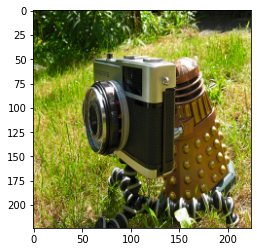

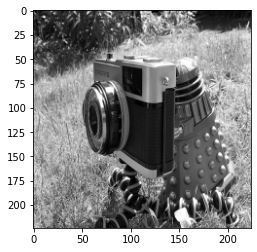

In [ ]:
index = 1579
l_sample,ab_sample = gray_scale[index].reshape((224,224,1)),ab_scale[index]
rgb_sample = rgb_image(l_sample,ab_sample)
display(rgb_sample)
display(l_sample[:,:,0])

In [ ]:
x = np.zeros((3000,224,224,1))
y = np.zeros((3000,224,224,2))

for i in range(3000):
    l_sample = normalize(gray_scale[i])
    ab_sample = normalize(ab_scale[i])
    x[i] = l_sample.reshape((224,224,1))
    y[i] = ab_sample  

In [ ]:
from keras import *
from keras.layers import *
from keras.activations import *
from keras.optimizers import *
from matplotlib import pyplot as plt
# from utils import *
from keras.initializers import RandomNormal, Zeros

Using TensorFlow backend.


In [ ]:
def residual_block(feature, dropout=False):
    x = Conv2D(128, kernel_size=3, strides=1, padding='same', kernel_initializer=RandomNormal(
        mean=0.0, stddev=0.02), bias_initializer=Zeros())(feature)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    if dropout:
        x = Dropout(0.5)(x)
    x = Conv2D(128, kernel_size=3, strides=1, padding='same', kernel_initializer=RandomNormal(
        mean=0.0, stddev=0.02), bias_initializer=Zeros())(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return Add()([feature, x])


def build_model(n_block=5):
    image_size = 224
    input_channel = 1
    output_channel = 2
    input = Input(shape=(image_size, image_size, input_channel))
    x = Conv2D(224, kernel_size=7, padding='same', kernel_initializer=RandomNormal(
        mean=0.0, stddev=0.02), bias_initializer=Zeros())(input)  # use reflection padding instead
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # downsample
    x = Conv2D(200, kernel_size=3, strides=2, padding='same', kernel_initializer=RandomNormal(
        mean=0.0, stddev=0.02), bias_initializer=Zeros())(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # downsample
    x = Conv2D(128, kernel_size=3, strides=2, padding='same', kernel_initializer=RandomNormal(
        mean=0.0, stddev=0.02), bias_initializer=Zeros())(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    for i in range(n_block):
        x = residual_block(x)
    # upsample
    x = Conv2DTranspose(200, kernel_size=3, strides=2, padding='same',
                        kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), bias_initializer=Zeros())(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # upsample
    x = Conv2DTranspose(224, kernel_size=3, strides=2, padding='same', kernel_initializer=RandomNormal(
        mean=0.0, stddev=0.02), bias_initializer=Zeros())(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # out
    x = Conv2D(output_channel, kernel_size=7, padding='same', kernel_initializer=RandomNormal(
        mean=0.0, stddev=0.02), bias_initializer=Zeros())(x)  # use reflection padding instead
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    model = Model(inputs=input, outputs=x)
    model.summary()
    return model


    

def save_images(generator, samples):
    ab_values = generator.predict(samples)
    plt.figure()
    plt.set_cmap('gray')
    for i in range(ab_values.shape[0]):
        l_val = unnormalize(samples[i])
        ab_val = unnormalize(ab_values[i])
        rgb = rgb_image(l_val, ab_val)
        if i == 0:
            display(rgb)
        ax = plt.subplot(224, 224, i+1)
        im = ax.imshow(rgb)
        # plt.tight_layout()
        plt.title(i)
    plt.show()
    plt.savefig('gan_generated_image.png')


    
def train_network(x_data,y_data,epochs=100, batch_size=128, save_interval=5):
    input_shape = (224, 224, 1)
    output_shape = (224, 224, 2)
    model = build_model(0)
    model.compile(optimizer='adam', loss='mse', metrics=['mse','acc'])
    history = model.fit(x_data,y_data,validation_split=0.1,epochs=epochs,batch_size=128,)
    model.save('/content/drive/My Drive/model1.h5')
    print("MODEL SAVED")
    return model,history
    

In [ ]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

In [ ]:
inputs = Input((224, 224, 1))
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

In [ ]:
up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
conv10 = Conv2D(2, (3, 3), activation='relu', padding='same')(conv9)

model = Model(inputs=[inputs], outputs=[conv10])
model.compile(optimizer='adam', loss='mse', metrics=['acc'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 224, 224, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 112, 112, 32) 0           conv2d_2[0][0]                   
____________________________________________________________________________________________

In [ ]:
x.shape

(3000, 224, 224, 1)

In [ ]:
samples = x.shape[0]
epochs = 500
x = x.reshape((samples,224,224,1))
history = model.fit(x,y,validation_split=0.1,epochs=epochs,batch_size=128,)
model.save('model.h5')

Train on 2700 samples, validate on 300 samples
Epoch 1/500
2700/2700 [==============================] - 72s 27ms/step - loss: 0.1603 - acc: 0.4969 - val_loss: 0.0268 - val_acc: 0.4855
Epoch 2/500
2700/2700 [==============================] - 40s 15ms/step - loss: 0.0110 - acc: 0.5042 - val_loss: 0.0072 - val_acc: 0.5155
Epoch 3/500
2700/2700 [==============================] - 41s 15ms/step - loss: 0.0061 - acc: 0.5195 - val_loss: 0.0066 - val_acc: 0.5231
Epoch 4/500
2700/2700 [==============================] - 41s 15ms/step - loss: 0.0054 - acc: 0.5287 - val_loss: 0.0062 - val_acc: 0.5292
Epoch 5/500
2700/2700 [==============================] - 41s 15ms/step - loss: 0.0051 - acc: 0.5283 - val_loss: 0.0052 - val_acc: 0.5161
Epoch 6/500
2700/2700 [==============================] - 41s 15ms/step - loss: 0.0047 - acc: 0.5233 - val_loss: 0.0051 - val_acc: 0.5140
Epoch 7/500
2700/2700 [==============================] - 41s 15ms/step - loss: 0.0045 - acc: 0.5372 - val_loss: 0.0047 - val_acc: 0

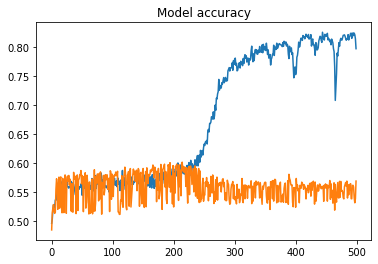

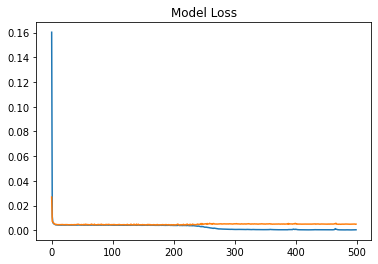

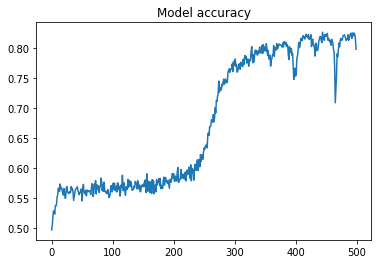

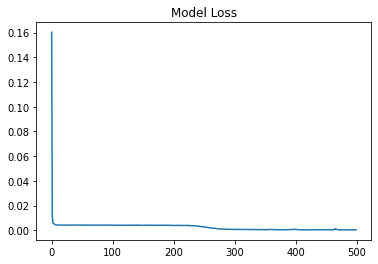

In [ ]:
h = history
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.title('Model accuracy')
plt.show()

plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('Model Loss')
plt.show()

plt.plot(h.history['acc'])
plt.title('Model accuracy')
plt.show()

plt.plot(h.history['loss'])
plt.title('Model Loss')
plt.show()

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/My Drive/model_new.h5')

In [ ]:
ab = model.predict(x[2000:2010])
ab

array([[[[0.48813397, 0.42085415],
         [0.5036074 , 0.43184346],
         [0.49405557, 0.4194746 ],
         ...,
         [0.50412303, 0.49331766],
         [0.5039169 , 0.5060438 ],
         [0.4919312 , 0.48316264]],

        [[0.4988202 , 0.42980146],
         [0.50343174, 0.43630028],
         [0.49851227, 0.4302802 ],
         ...,
         [0.5131841 , 0.50525635],
         [0.50480306, 0.5070322 ],
         [0.49731117, 0.48925126]],

        [[0.50416034, 0.43083578],
         [0.51522195, 0.43108505],
         [0.5053941 , 0.42167884],
         ...,
         [0.50437874, 0.50583035],
         [0.5015058 , 0.5012921 ],
         [0.5071819 , 0.4992841 ]],

        ...,

        [[0.49969822, 0.5937541 ],
         [0.49592894, 0.60864145],
         [0.4984041 , 0.617715  ],
         ...,
         [0.46350795, 0.56245846],
         [0.4591804 , 0.56097716],
         [0.45688343, 0.57315505]],

        [[0.51273644, 0.5836384 ],
         [0.52273506, 0.58360064],
         [0.

In [ ]:
x.shape

(3000, 224, 224, 1)

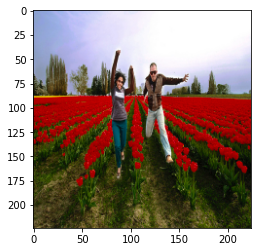

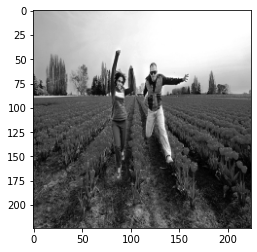

<Figure size 432x288 with 0 Axes>

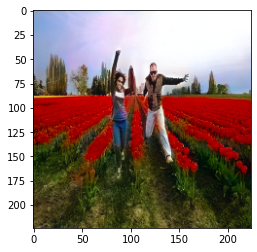

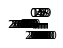

<Figure size 432x288 with 0 Axes>

In [ ]:
index = 2000
l_sample,ab_sample = gray_scale[index].reshape((224,224,1)),ab_scale[index]
rgb_sample = rgb_image(l_sample,ab_sample)
display(rgb_sample)
display(l_sample[:,:,0])
save_images(model,x[2000:2010])

In [ ]:
import tensorflow as tf


In [ ]:
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 

In [ ]:
from math import log10, sqrt 

In [ ]:
original = cv2.imread("/content/gan_generated_image.png") 
original  = cv2.resize(original,(224,224))
# compressed = cv2.imread("compressed_image.png", 1) 
value = PSNR(original, rgb_sample) 
print(f"PSNR value is {value} dB") 

PSNR value is 28.959779323592162 dB
